In [2]:
import pickle as pk
from imdb_indexer import word2index
import numpy as np
import pandas as pd
import itertools
import os
from functions import make_ngram, uptoNgram
import tqdm
import matplotlib.pyplot as plt
from bow import BagOfWords, test_model


In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset

class IMDbDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

## setting: 
### nltk tokenization, 1+2-gram, vocab_size =50000,  emb_size = 300, adam optimizer, learning rate = 0.01, max sentence length = 90 percentile of training feature length

In [4]:
ngram_dct = pk.load(open("ngram_dct_nltk.pk", "rb"))
train_label = pk.load(open("train_label.pk", "rb"))
test_label = pk.load(open("test_label.pk", "rb"))
val_label = pk.load(open("val_label.pk", "rb"))

In [9]:
#create upto2gram_nltk first
upto2gram = uptoNgram(2, ngram_dct)

In [10]:
upto2gram.keys()

dict_keys(['train', 'val', 'test'])

In [11]:
train_features = upto2gram['train']
val_features = upto2gram['val']
test_features = upto2gram['test']

In [17]:
print(train_features[1])

['hear', 'prais', 'thi', 'play', 'decid', 'watch', 'stumbl', 'across', 'cabl', 'see', 'thi', 'eliv', 'women', 'struggl', 'focus', 'topic', 'hand', 'guess', 'interest', 'stori', 'women', 'privat', 'part', 'affect', 'live', 'thi', 'otherwis', 'rather', 'dull', 'bore', 'anyth', 'found', 'bit', 'br', 'br', 'inquir', 'femal', 'friend', 'also', 'watch', 'thi', 'thought', 'wa', 'horribl', 'well', 'guy', 'get', 'hear prais', 'prais thi', 'thi play', 'play decid', 'decid watch', 'watch stumbl', 'stumbl across', 'across cabl', 'cabl see', 'see thi', 'thi eliv', 'eliv women', 'women struggl', 'struggl focus', 'focus topic', 'topic hand', 'hand guess', 'guess interest', 'interest stori', 'stori women', 'women privat', 'privat part', 'part affect', 'affect live', 'live thi', 'thi otherwis', 'otherwis rather', 'rather dull', 'dull bore', 'bore anyth', 'anyth found', 'found bit', 'bit br', 'br br', 'br inquir', 'inquir femal', 'femal friend', 'friend also', 'also watch', 'watch thi', 'thi thought', '

In [18]:
feature_length = np.array([len(x) for x in train_features])
MAX_SENTENCE_LENGTH = int(np.percentile(feature_length, 90))
MAX_SENTENCE_LENGTH

505

In [19]:
max_vocab_size = 50000
learning_rate = 0.01
num_epochs = 10
emb_dim = 300

PAD_IDX = 0
UNK_IDX = 1
all_train_features = list(itertools.chain.from_iterable(train_features))

builder = word2index(PAD_IDX, UNK_IDX)
#build vocab
token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
train_data_indices = builder.token2index_dataset(train_features)
val_data_indices = builder.token2index_dataset(val_features)
test_data_indices = builder.token2index_dataset(test_features)


# create pytorch dataloader
BATCH_SIZE = 64
train_dataset = IMDbDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = IMDbDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

test_dataset = IMDbDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)


model = BagOfWords(len(id2token), emb_dim)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
val_acc_list = []
for epoch in tqdm.trange(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        val_acc = test_model(val_loader, model)
        optimizer.step()

    val_acc_list.append(val_acc)

print('finish, val_acc: %s' %(test_model(val_loader, model)))

In [22]:
val_acc

88.86

Text(0.5,1,'final model')

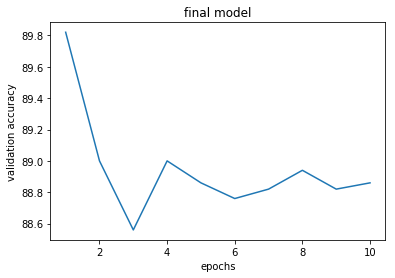

In [24]:
plt.plot(np.arange(1,num_epochs+1), val_acc_list)
#plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('final model')

In [26]:
val_acc_list_2 = []

In [ ]:
max_vocab_size = 50000
learning_rate = 0.001
num_epochs = 10
emb_dim = 300

model = BagOfWords(len(id2token), emb_dim)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
val_acc_list = []
for epoch in tqdm.trange(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        val_acc = test_model(val_loader, model)
        optimizer.step()

    val_acc_list_2.append(val_acc)

print('finish, val_acc: %s' %(test_model(val_loader, model)))



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [08:42<1:18:22, 522.52s/it]

 20%|██        | 2/10 [17:23<1:09:33, 521.73s/it]

 30%|███       | 3/10 [26:07<1:00:56, 522.40s/it]

 40%|████      | 4/10 [34:47<52:11, 521.92s/it]  